In [1]:
from ultralytics import YOLO
import cv2
from pathlib import Path
import os

In [2]:
model = YOLO("yolo11l")

## Prediction on Video with YOLO

In [3]:
import time
from PIL import Image
from IPython.display import display, clear_output

In [4]:
# Function to predict with the chosen model
def predict(chosen_model, img, classes=[], conf=0.5):
    # Check if classes are specified for filtering
    if classes:
        results = chosen_model.predict(img, classes=classes, conf=conf)
    else:
        results = chosen_model.predict(img, conf=conf)

    return results

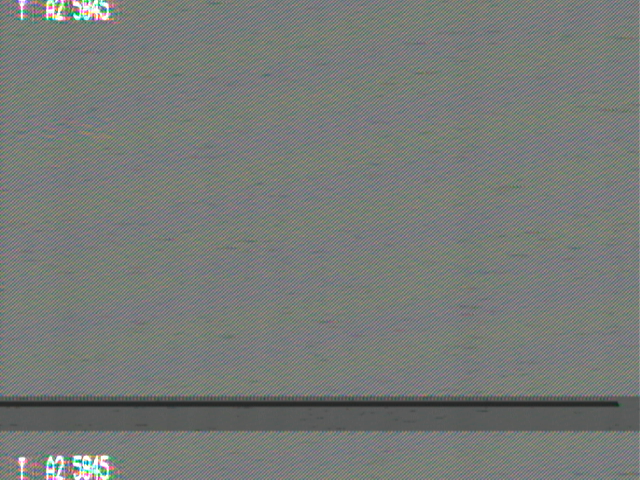

Video saved successfully at output_normalized_video.mp4.


In [10]:
def show_video_in_notebook_and_save(model, output_path, target_fps=30, classes=[], conf=0.5):
    import signal

    # Open the video file or camera
    cap = cv2.VideoCapture(1)  # Change to file path for a video file, or '0' for default camera

    if not cap.isOpened():
        print("Error: Could not open video source.")
        return

    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    input_fps = cap.get(cv2.CAP_PROP_FPS) or target_fps  # Use the input FPS if available

    print(f"Input FPS: {input_fps}, Target FPS: {target_fps}")

    # Define the codec and create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # For .mp4 format
    out = cv2.VideoWriter(output_path, fourcc, target_fps, (frame_width, frame_height))

    if not out.isOpened():
        print("Error: Could not open VideoWriter.")
        return

    rectangle_thickness = 1
    text_thickness = 1

    # Set up a stop flag
    stop_flag = False

    def signal_handler(sig, frame):
        nonlocal stop_flag
        print("Exiting the loop...")
        stop_flag = True

    # Register the signal handler
    signal.signal(signal.SIGINT, signal_handler)

    frame_interval = 1 / target_fps  # Time interval between frames for the target FPS
    frame_count = 0  # Counter for processed frames

    while not stop_flag:
        start_time = time.time()

        ret, frame = cap.read()
        if not ret:
            print("No more frames to process or camera error.")
            break

        # Perform inference using YOLO model (Optional - if inference is needed)
        img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = predict(model, img_rgb, classes, conf=conf)

        if isinstance(results, list):
            results = results[0]

        # Draw detections
        for result in results:
            for box in result.boxes:
                x1, y1, x2, y2 = int(box.xyxy[0][0]), int(box.xyxy[0][1]), int(box.xyxy[0][2]), int(box.xyxy[0][3])
                cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), rectangle_thickness)
                class_name = result.names[int(box.cls[0])]
                cv2.putText(frame, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_PLAIN, 1, (255, 0, 0), text_thickness)

        # Write the frame to the video file
        out.write(frame)
        frame_count += 1

        # Display the frame in the notebook
        im_pil = Image.fromarray(frame)
        clear_output(wait=True)
        display(im_pil)

        # Ensure the loop respects the target FPS
        elapsed_time = time.time() - start_time
        sleep_time = max(0, frame_interval - elapsed_time)
        time.sleep(sleep_time)

    # Release resources
    cap.release()
    out.release()

    if frame_count > 0:
        print(f"Video saved successfully at {output_path}.")
    else:
        print("No frames were processed. Video file not created.")




output_file = "output_normalized_video.mp4"
show_video_in_notebook_and_save(model, output_file, target_fps=12)